Music Genre Predictionn

In [ ]:
#first model

In [ ]:
import os
import numpy as np
import warnings
import seaborn as sns

# Suppress TensorFlow-related warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
!unzip data1.zip  -d '/content/data1/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
Archive:  data1.zip
   creating: /content/data1/data1/Data/
  inflating: /content/data1/data1/Data/features_3_sec.csv  
  inflating: /content/data1/data1/Data/features_30_sec.csv  
   creating: /content/data1/data1/Data/genres_original/
   creating: /content/data1/data1/Data/genres_original/blues/
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00000.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00001.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00002.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00003.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00004.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00005.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00006.wav  
  inflating: /content/data1/data1/Data/genres_original/blues/blues.00007.wav  
  i

In [ ]:
data_dir = '/content/data1/data1/Data'
labels=os.listdir(data_dir)
labels

['features_30_sec.csv',
 'genres_original',
 'features_3_sec.csv',
 'images_original']

In [ ]:
import os
import enum
import glob

import tqdm
import tensorflow as tf
import librosa as lr
import numpy as np
import pandas as pd

assert tf.__version__ == "2.14.0" and tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# Updating the path to unzipped data directory
data_dir = '/content/data1/data1/Data/genres_original'

# Checking the file paths in the data directory
paths = glob.glob(os.path.join(data_dir, "*/*.wav"))
print("Number of audio files:", len(paths))

# Checking the structure of the data
df = pd.DataFrame({"path": paths})
df["genre"] = df.path.apply(lambda x: x.split("/")[-2])
print(df.head())

Number of audio files: 999
                                                path    genre
0  /content/data1/data1/Data/genres_original/coun...  country
1  /content/data1/data1/Data/genres_original/coun...  country
2  /content/data1/data1/Data/genres_original/coun...  country
3  /content/data1/data1/Data/genres_original/coun...  country
4  /content/data1/data1/Data/genres_original/coun...  country


**Genre Vs Duration and Genre vs no. of tracks plot**

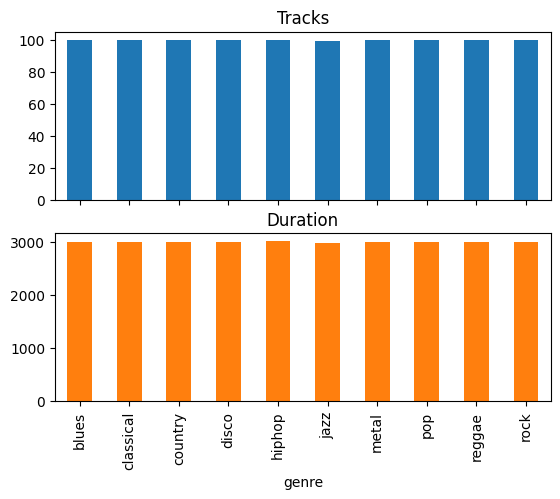

In [ ]:
def load_metadata() -> pd.DataFrame:
    # Updating the path to be relative to the data_dir
    paths = glob.glob(os.path.join(data_dir, "*/*.wav"))
    df = pd.DataFrame({"path": paths})
    df["genre"] = df.path.apply(lambda x: x.rsplit("/")[-2])
    df["duration"] = df.path.apply(lambda x: lr.get_duration(filename=x))
    df["samplerate"] = df.path.apply(lr.get_samplerate)
    return df

metadata = load_metadata()
groups = metadata.groupby("genre")

# Checking if there are any groups in the DataFrameGroupBy
if groups.ngroups > 0:
    pd.DataFrame({
        'Tracks': groups.path.count(),
        'Duration': groups.duration.sum()
    }).plot.bar(subplots=True, legend=None)
else:
    print("No data to plot.")

**Sampled signal plot for one of the audio tracks**

In [ ]:
import time
import matplotlib.pyplot as plt

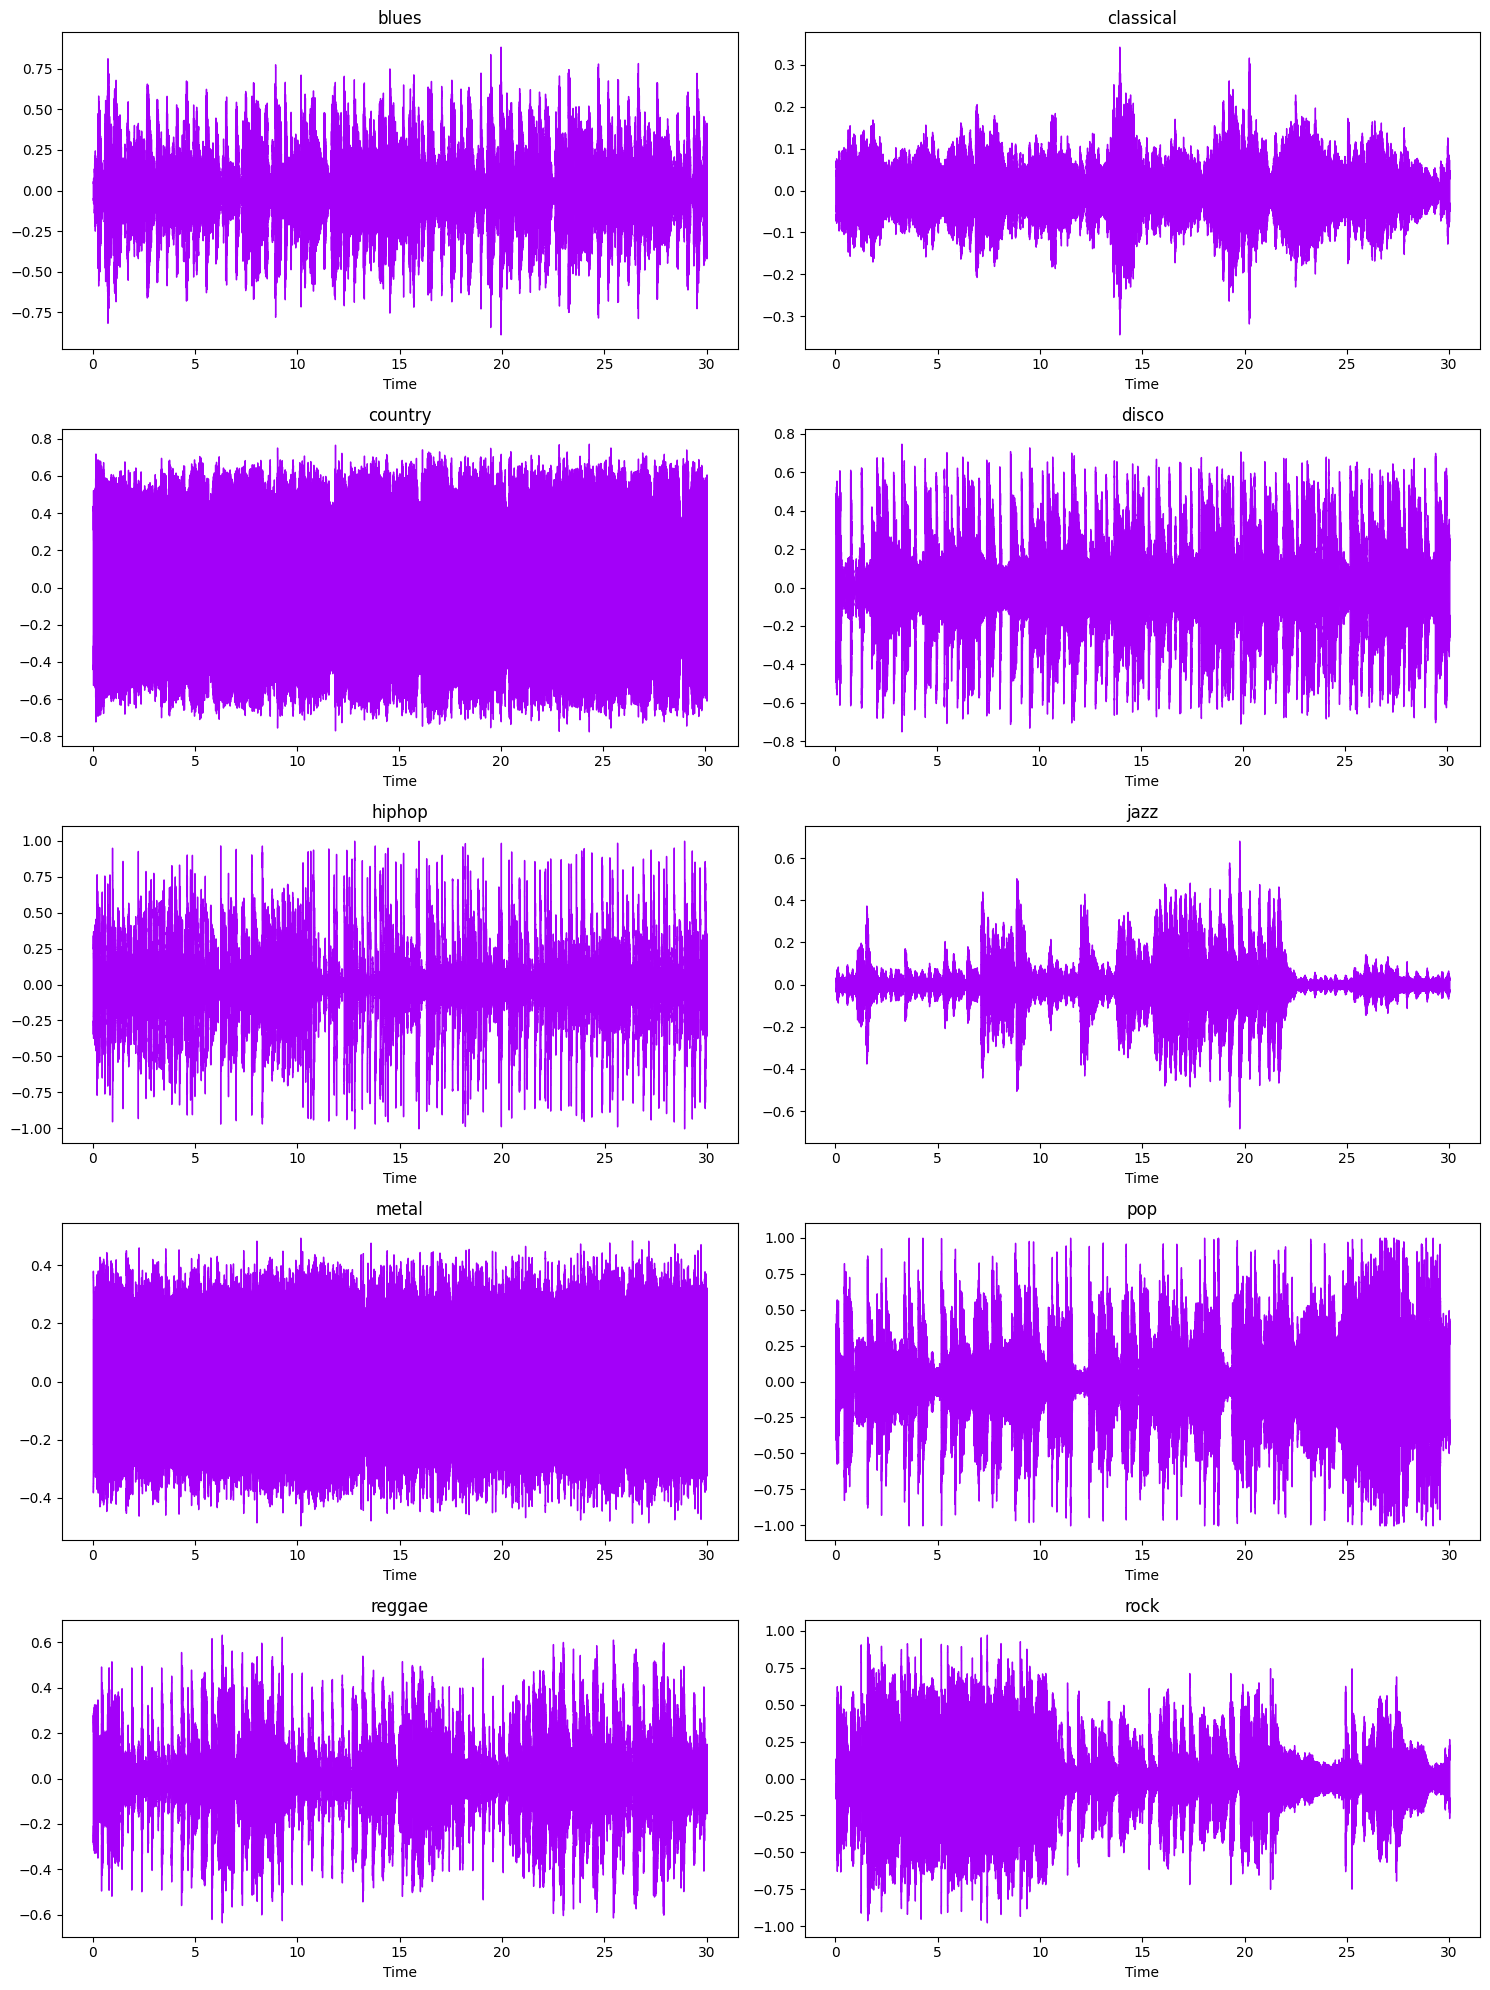

In [ ]:
genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}
hop_length = 512

n_fft = 2048

fig, axes= plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
i = 0
j = 0
for genre in genre_dict.keys():
    # Reading the first audio file
    data,sampling_rate = lr.load(data_dir + "/" + genre + "/" + genre + ".00000.wav")

    lr.display.waveshow(y = data, sr = sampling_rate, color = "#A300F9",ax=axes[i][j])


    axes[i][j].set_title(genre)

    if(j == 1):
        i = i + 1
        j = 0
    else:
        j = j + 1

plt.tight_layout()
plt.show()

**Generate and display a spectrogram of the signal 'y' using the 'inferno' colormap.**

In [ ]:
cmap = plt.get_cmap('inferno')
time.sleep(1)

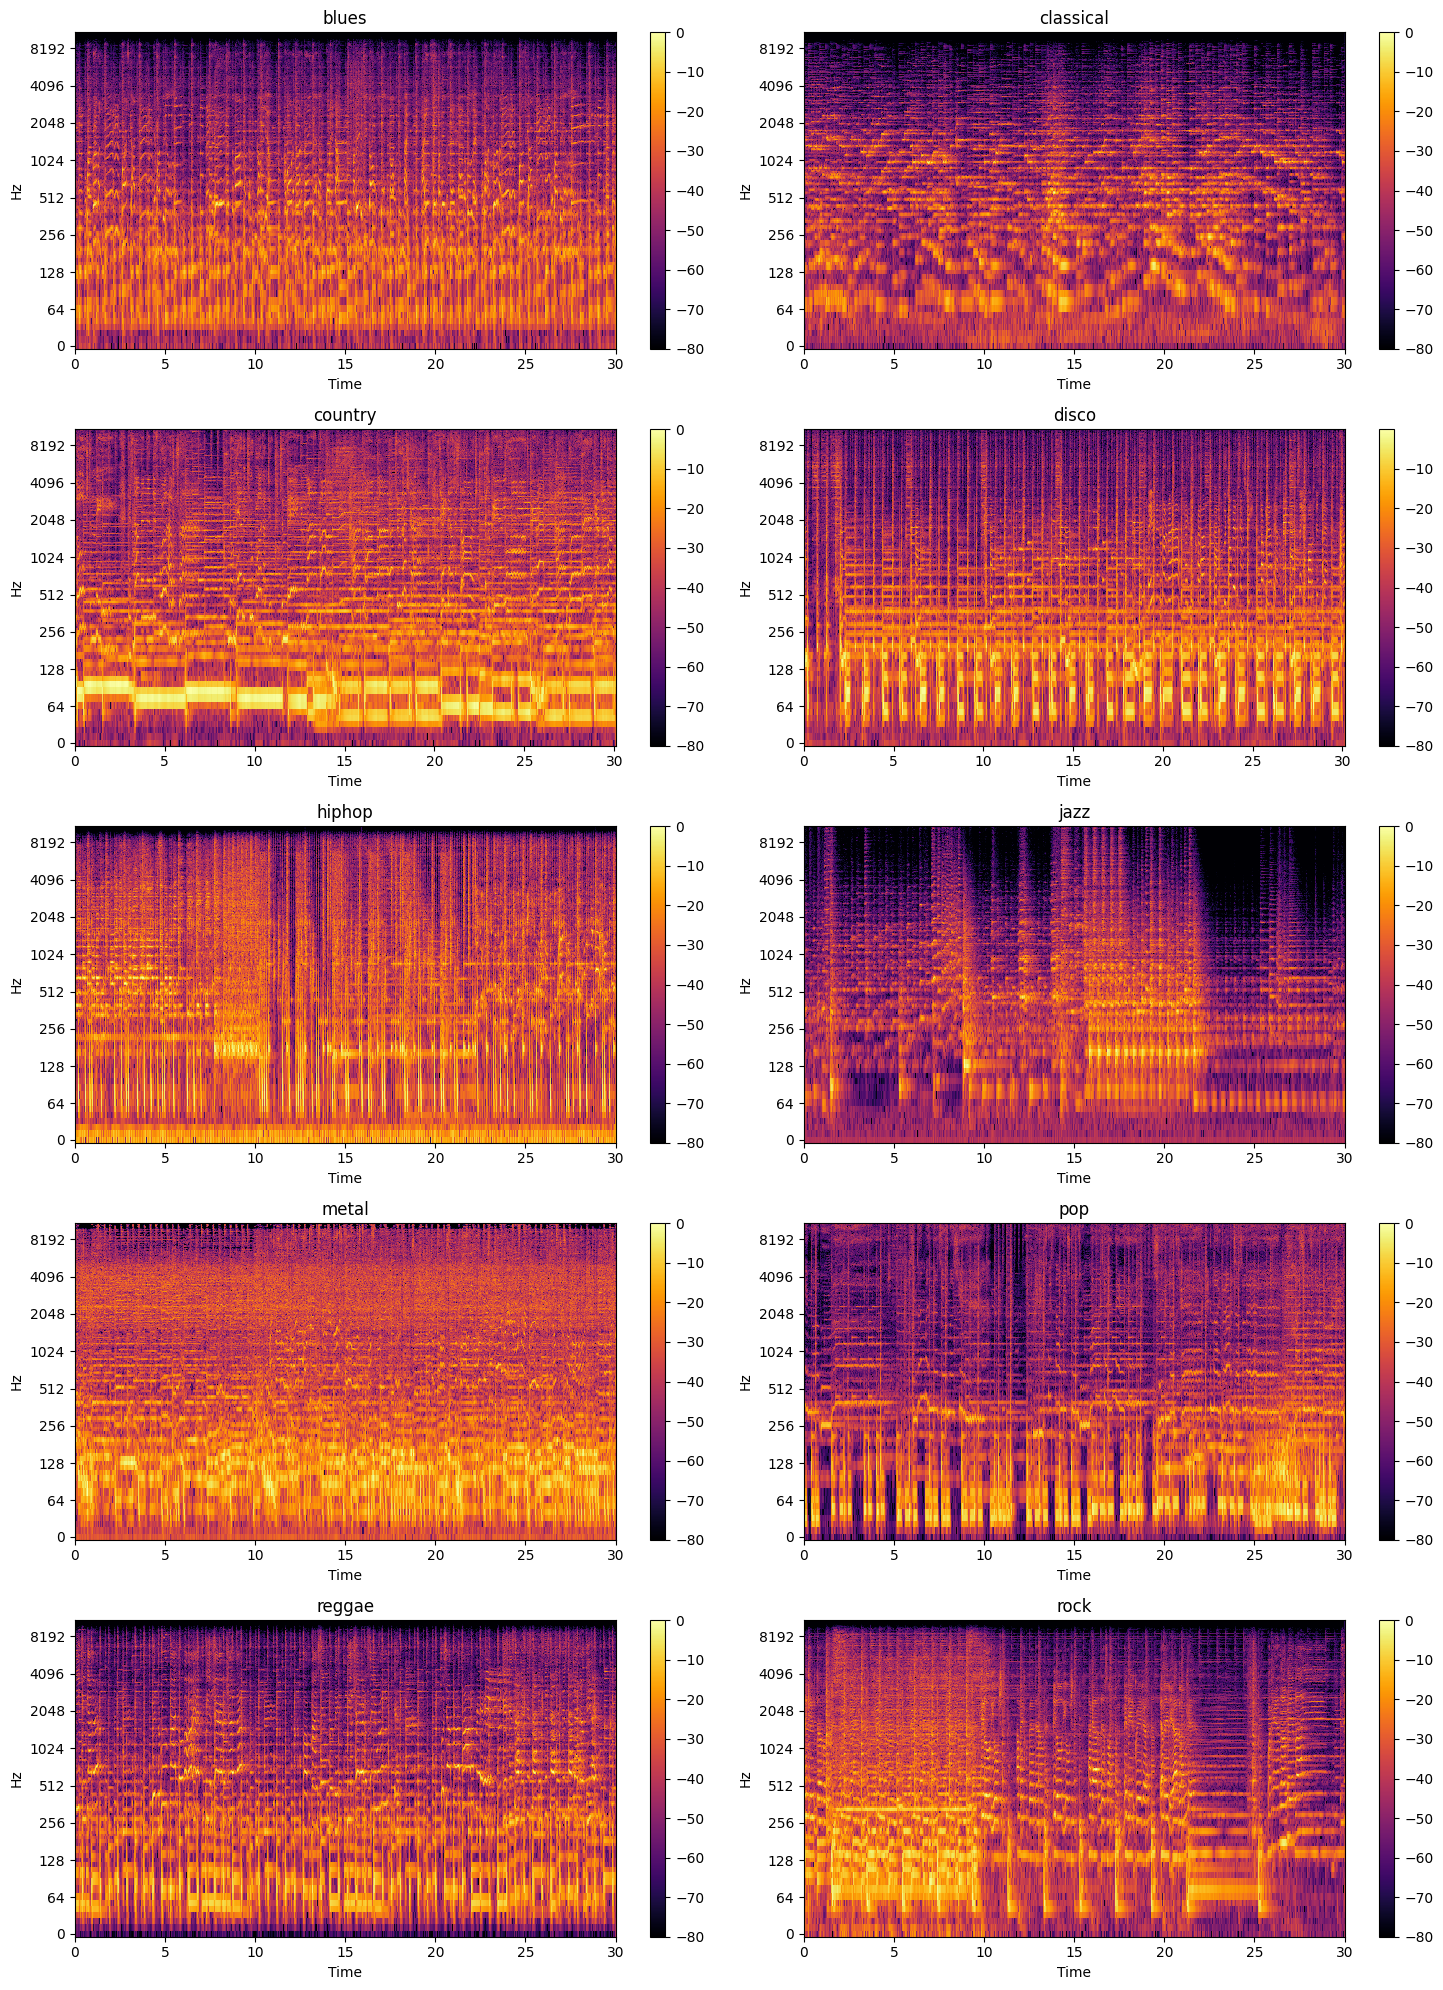

In [ ]:
from pandas.core.reshape.melt import lreshape
#spectrogram stuff
fig, axes= plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
i = 0
j = 0
for genre in genre_dict.keys():
    # Reading the first audio file
    data,sampling_rate = lr.load(data_dir +"/" + genre + "/" + genre + ".00000.wav")

    stft_data = np.abs(lr.stft(y = data, n_fft = n_fft,hop_length = hop_length))

    # Convert an amplitude spectrogram to Decibels-scaled spectrogram.
    DB = lr.amplitude_to_db(stft_data, ref = np.max)

    img = lr.display.specshow(DB, sr = sampling_rate, hop_length = hop_length, x_axis = 'time', y_axis = 'log',cmap = cmap,ax=axes[i][j])
    fig.colorbar(img, ax=axes[i][j])

    axes[i][j].set_title(genre)

    if(j == 1):
        i = i + 1
        j = 0
    else:
        j = j + 1

plt.tight_layout()
plt.show()


**Extract audio features from music files of various genres and save the data in a CSV file**

In [ ]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import csv

base_directory = '/content/data1/data1/Data/'
genres_directory = os.path.join(base_directory, 'genres_original')

header = 'filename chroma_stft_mean chroma_stft_var rmse_mean rmse_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var tempo_mean tempo_var'
for i in range(1, 21):
    header += f' mfcc{i}_mean mfcc{i}_var'
header += ' label'
header = header.split()

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
count = 0



for genre in genres:
    genre_directory = os.path.join(genres_directory, genre)
    for filename in os.listdir(genre_directory):
        songname = os.path.join(genre_directory, filename)
        # sampling of the input
        y, sr = lr.load(songname, duration=30)
        # parameter extraction
        chroma_stft = lr.feature.chroma_stft(y=y, sr=sr)
        rmse = lr.feature.rms(y=y)
        spec_cent = lr.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = lr.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = lr.feature.spectral_rolloff(y=y, sr=sr)
        zcr = lr.feature.zero_crossing_rate(y)
        tempo = lr.feature.tempo(y=y, sr=sr)
        mfcc = lr.feature.mfcc(y=y, sr=sr, n_mfcc=20)

        # preparing an input row for csv
        to_append = f'{filename} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.mean(rmse)} {np.var(rmse)} {np.mean(spec_cent)} {np.var(spec_cent)} {np.mean(spec_bw)} {np.var(spec_bw)} {np.mean(rolloff)} {np.var(rolloff)} {np.mean(zcr)} {np.var(zcr)} {np.mean(tempo)} {np.var(tempo)}'
        for e in mfcc:
            to_append += f' {np.mean(e)} {np.var(e)}'
        to_append += f' {genre}'

        count += 1
        print(f'{count}-{to_append}')

        # writing into csv
        with open('data.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

df = pd.read_csv('data.csv')


1-blues.00053.wav 0.4124908745288849 0.08584805577993393 0.16826629638671875 0.0036770456936210394 2171.15861919452 169984.3643464507 1954.1375650013151 84900.66201423662 4237.0993788397345 746349.4807013071 0.13280229598006965 0.002349041644220107 103.359375 0.0 -76.75776672363281 2906.818603515625 105.77047729492188 432.54132080078125 -43.20883560180664 390.8260803222656 60.95011520385742 407.6421203613281 -8.791271209716797 203.87620544433594 21.246780395507812 121.12483978271484 -12.877674102783203 165.4896697998047 18.621217727661133 148.7778778076172 -11.399116516113281 57.034915924072266 14.550057411193848 78.52515411376953 -6.057422161102295 68.96302795410156 12.740340232849121 64.47893524169922 -9.37436580657959 54.859439849853516 1.3606241941452026 64.23223114013672 -3.6204466819763184 57.118682861328125 7.00457763671875 44.6619758605957 -4.0630011558532715 60.580448150634766 -0.26885950565338135 52.60896301269531 -3.7049412727355957 54.57129669189453 -0.4966115653514862 56.8

In [ ]:
data = pd.read_csv('data.csv')
data

filename  chroma_stft_mean  chroma_stft_var  rmse_mean  rmse_var  \
0    blues.00053.wav          0.412491         0.085848   0.168266  0.003677   
1    blues.00062.wav          0.311819         0.092670   0.106193  0.000865   
2    blues.00069.wav          0.291983         0.086769   0.116540  0.000964   
3    blues.00093.wav          0.377736         0.096391   0.065891  0.001804   
4    blues.00096.wav          0.260613         0.091856   0.051328  0.000854   
..               ...               ...              ...        ...       ...   
994   rock.00006.wav          0.344488         0.088056   0.180115  0.003576   
995   rock.00098.wav          0.362428         0.091507   0.083834  0.001206   
996   rock.00032.wav          0.383478         0.087220   0.222140  0.002448   
997   rock.00015.wav          0.343717         0.092382   0.082300  0.003100   
998   rock.00095.wav          0.351992         0.080493   0.079441  0.000346   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               2171.158619           1.699844e+05              1954.137565   
1               2279.808618           4.224434e+05              2119.671733   
2               2370.963292           2.367796e+05              2209.514584   
3                570.150688           1.049516e+05               995.093473   
4               1132.518423           3.192689e+05              1582.765488   
..                      ...                    ...                      ...   
994             1675.499937           2.094681e+05              1653.116147   
995             1398.581575           2.405920e+05              1817.813570   
996             2345.885737           2.776614e+05              2378.385172   
997             2336.111676           1.047623e+06              2099.311747   
998             2008.537045           2.821445e+05              2106.349206   

     spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0              84900.662014   4237.099379  ...   44.661976    -4.063001   
1              36012.917299   4732.271385  ...   79.247917    -9.326942   
2              42942.051672   5004.086408  ...   60.178383   -10.407991   
3              84457.870140    928.852717  ...   35.267281    -3.708839   
4             151549.766831   2066.245839  ...  168.602524    -5.665494   
..                      ...           ...  ...         ...          ...   
994            80430.795241   3253.796991  ...   63.206573    -8.634934   
995           109079.454152   3014.673437  ...   46.330338    -4.421223   
996           100192.866546   4735.771363  ...   53.675617    -5.878407   
997           186148.637618   4501.422781  ...   64.319893    -8.139413   
998            88618.861488   4254.124276  ...   45.016090   -13.300427   

     mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0     60.580448    -0.268860   52.608963    -3.704941   54.571297   
1     90.602844     5.140728  220.347046    -8.113004  102.790634   
2     59.104572    -2.048969  115.386948    -1.765213  104.840012   
3     34.146069     0.175169   34.543175     2.076679   44.244167   
4    149.457825     1.562117  165.357239     0.897125  176.932663   
..          ...          ...         ...          ...         ...   
994   65.679352    -1.901795   52.827236    -2.187008   41.129757   
995   43.654392     1.560510   34.356205    -5.046413   47.208336   
996   43.858891    -1.550975   47.145779    -6.817296   54.644985   
997   77.211479    -5.716430   62.092590    -3.364279   47.116028   
998   41.649334     2.473230   36.610485    -6.719625   54.840275   

     mfcc20_mean  mfcc20_var  label  
0      -0.496612   56.846924  blues  
1      -2.449215  109.611755  blues  
2      -3.952849   77.190681  blues  
3      -2.892004   61.476616  blues  
4      -7.956727  138.172714  blues  
..           ...         ...    ...  
994    -3.391345   44.944019   rock  
995    -3.582565   41.294521   rock  
996    -1.380838   54.432480  

**Encode the genre labels using LabelEncoder and obtain the shape and first five encoded values**

In [ ]:
from sklearn.preprocessing import LabelEncoder
genre_list = data.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
y.shape , y[:5]


((999,), array([0, 0, 0, 0, 0]))

In [ ]:
data1 = data.drop(['filename','label'],axis=1)
data1

chroma_stft_mean  chroma_stft_var  rmse_mean  rmse_var  \
0            0.412491         0.085848   0.168266  0.003677   
1            0.311819         0.092670   0.106193  0.000865   
2            0.291983         0.086769   0.116540  0.000964   
3            0.377736         0.096391   0.065891  0.001804   
4            0.260613         0.091856   0.051328  0.000854   
..                ...              ...        ...       ...   
994          0.344488         0.088056   0.180115  0.003576   
995          0.362428         0.091507   0.083834  0.001206   
996          0.383478         0.087220   0.222140  0.002448   
997          0.343717         0.092382   0.082300  0.003100   
998          0.351992         0.080493   0.079441  0.000346   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               2171.158619           1.699844e+05              1954.137565   
1               2279.808618           4.224434e+05              2119.671733   
2               2370.963292           2.367796e+05              2209.514584   
3                570.150688           1.049516e+05               995.093473   
4               1132.518423           3.192689e+05              1582.765488   
..                      ...                    ...                      ...   
994             1675.499937           2.094681e+05              1653.116147   
995             1398.581575           2.405920e+05              1817.813570   
996             2345.885737           2.776614e+05              2378.385172   
997             2336.111676           1.047623e+06              2099.311747   
998             2008.537045           2.821445e+05              2106.349206   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0              84900.662014   4237.099379  7.463495e+05  ...     7.004578   
1              36012.917299   4732.271385  7.812753e+05  ...    -1.415343   
2              42942.051672   5004.086408  4.846835e+05  ...    -4.920230   
3              84457.870140    928.852717  5.000304e+05  ...    -1.775328   
4             151549.766831   2066.245839  1.738502e+06  ...    -9.362388   
..                      ...           ...           ...  ...          ...   
994            80430.795241   3253.796991  7.294291e+05  ...    -5.695947   
995           109079.454152   3014.673437  1.332874e+06  ...    -2.814905   
996           100192.866546   4735.771363  1.188173e+06  ...    -2.463733   
997           186148.637618   4501.422781  2.909037e+06  ...     0.799260   
998            88618.861488   4254.124276  1.222833e+06  ...     1.805271   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     44.661976    -4.063001   60.580448    -0.268860   52.608963   
1     79.247917    -9.326942   90.602844     5.140728  220.347046   
2     60.178383   -10.407991   59.104572    -2.048969  115.386948   
3     35.267281    -3.708839   34.146069     0.175169   34.543175   
4    168.602524    -5.665494  149.457825     1.562117  165.357239   
..          ...          ...         ...          ...         ...   
994   63.206573    -8.634934   65.679352    -1.901795   52.827236   
995   46.330338    -4.421223   43.654392     1.560510   34.356205   
996   53.675617    -5.878407   43.858891    -1.550975   47.145779   
997   64.319893    -8.139413   77.211479    -5.716430   62.092590   
998   45.016090   -13.300427   41.649334     2.473230   36.610485   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0      -3.704941   54.571297    -0.496612   56.846924  
1      -8.113004  102.790634    -2.449215  109.611755  
2      -1.765213  104.840012    -3.952849   77.190681  
3       2.076679   44.244167    -2.892004   61.476616  
4       0.897125  176.932663    -7.956727  138.172714  
..           ...         ...          ...         ...  
994    -2.187008   41.129757    -3.391345   44.944019  
995    -5.046413   47.208336    -3.582565   41.294521  
996    -6.817296   54.644985    -1.380838

**Standardize the features in 'data1' using StandardScaler and store the standardized data in 'x'**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x = scaler.fit_transform(np.array(data1,dtype = float))
x

array([[ 0.41270712, -0.06462553,  0.57002767, ..., -0.31351077,
         0.1558385 , -0.29241726],
       [-0.8203835 ,  0.81667779, -0.37547228, ...,  0.98312017,
        -0.35296383,  0.87444624],
       [-1.06334877,  0.05439208, -0.2178621 , ...,  1.03822848,
        -0.74477546,  0.15747309],
       ...,
       [ 0.05733697,  0.11259722,  1.39062323, ..., -0.31152926,
        -0.07456994, -0.34581128],
       [-0.42967517,  0.77945633, -0.73941292, ..., -0.51398495,
         0.17533038, -0.0631656 ],
       [-0.32832362, -0.75642888, -0.78294911, ..., -0.30627787,
        -0.02725714, -0.44381806]])

**splitting the data**

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X_train , X_test , y_train , y_test = train_test_split(x,y,test_size=0.20)
print(f'X_train : {X_train.shape} , X_test : {X_test.shape} , y_train : {y_train.shape} , y_test : {y_test.shape}')

X_train : (799, 54) , X_test : (200, 54) , y_train : (799,) , y_test : (200,)


**Using KNN (model 0)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f'Accuracy: {accuracy_knn * 100:.2f}%')

Accuracy: 64.50%


**Using SVM(Model 1)**

In [ ]:
from sklearn.svm import SVC

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred1 = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred1)

# Print a classification report
print(classification_report(y_test, y_pred1))


              precision    recall  f1-score   support

           0       0.57      0.60      0.59        20
           1       0.96      0.96      0.96        23
           2       0.52      0.59      0.55        22
           3       0.48      0.58      0.52        19
           4       0.83      0.53      0.65        19
           5       0.83      0.75      0.79        20
           6       0.84      0.70      0.76        23
           7       0.81      0.68      0.74        19
           8       0.60      0.75      0.67        16
           9       0.39      0.47      0.43        19

    accuracy                           0.67       200
   macro avg       0.68      0.66      0.67       200
weighted avg       0.69      0.67      0.67       200



**Ensemble of SVMs(Model2)**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

# Creating individual SVM classifiers with different hyperparameters
svm_classifier_1 = SVC(kernel='linear', C=1.0)
svm_classifier_2 = SVC(kernel='rbf', C=1.0, gamma=0.001)
svm_classifier_3 = SVC(kernel='poly', C=1.0, degree=3)

# Creating a voting ensemble classifier
ensemble_classifier = VotingClassifier(estimators=[
    ('svm_linear', svm_classifier_1),
    ('svm_rbf', svm_classifier_2),
    ('svm_poly', svm_classifier_3)
], voting='hard')  # 'hard' for majority class voting, 'soft' for probability-based voting

# Training the ensemble classifier on the training data
ensemble_classifier.fit(X_train, y_train)

# Making predictions using the ensemble classifier
y_pred2 = ensemble_classifier.predict(X_test)


In [ ]:
# Calculating accuracy
accuracy1 = accuracy_score(y_test, y_pred2)

# Printing a classification report
print(classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.45      0.50      0.48        20
           1       0.92      0.96      0.94        23
           2       0.48      0.68      0.57        22
           3       0.45      0.79      0.58        19
           4       1.00      0.37      0.54        19
           5       0.76      0.65      0.70        20
           6       0.78      0.78      0.78        23
           7       0.86      0.63      0.73        19
           8       0.62      0.62      0.62        16
           9       0.38      0.26      0.31        19

    accuracy                           0.64       200
   macro avg       0.67      0.62      0.62       200
weighted avg       0.68      0.64      0.63       200



**CNN(Model 3)**

In [ ]:
from keras import models
from keras import layers

model3 = models.Sequential([

layers.Dense(256 , activation = 'relu' , input_shape=(X_train.shape[1],)),
layers.Dropout(0.5),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(10 , activation = 'softmax')

])


In [ ]:
model3.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model3.fit(X_train,y_train,epochs=500,batch_size=128)

Epoch 1/500
7/7 [==============================] - 7s 5ms/step - loss: 2.5211 - accuracy: 0.1214
Epoch 2/500
7/7 [==============================] - 0s 4ms/step - loss: 2.3155 - accuracy: 0.1552
Epoch 3/500
7/7 [==============================] - 0s 4ms/step - loss: 2.2211 - accuracy: 0.1802
Epoch 4/500
7/7 [==============================] - 0s 4ms/step - loss: 2.1581 - accuracy: 0.2265
Epoch 5/500
7/7 [==============================] - 0s 4ms/step - loss: 2.1241 - accuracy: 0.2240
Epoch 6/500
7/7 [==============================] - 0s 4ms/step - loss: 2.0286 - accuracy: 0.2741
Epoch 7/500
7/7 [==============================] - 0s 4ms/step - loss: 1.9456 - accuracy: 0.2753
Epoch 8/500
7/7 [==============================] - 0s 4ms/step - loss: 1.9190 - accuracy: 0.3116
Epoch 9/500
7/7 [==============================] - 0s 4ms/step - loss: 1.8958 - accuracy: 0.3392
Epoch 10/500
7/7 [==============================] - 0s 4ms/step - loss: 1.8674 - accuracy: 0.3154
Epoch 11/500
7/7 [===========

In [ ]:
test_loss3 , test_acc3 = model3.evaluate(X_test,y_test)

7/7 [==============================] - 1s 8ms/step - loss: 1.3899 - accuracy: 0.7400


**CNN(Model 4)**

In [ ]:
import tensorflow.keras as keras

# Build network topology
model4 = keras.Sequential()

# Input shape should be (num_features, 1)
input_shape = (X_train.shape[1], 1)

# 1st conv layer
model4.add(keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
model4.add(keras.layers.MaxPooling1D(3, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# 2nd conv layer
model4.add(keras.layers.Conv1D(32, 3, activation='relu'))
model4.add(keras.layers.MaxPooling1D(3, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# 3rd conv layer
model4.add(keras.layers.Conv1D(32, 2, activation='relu'))
model4.add(keras.layers.MaxPooling1D(2, strides=2, padding='same'))
model4.add(keras.layers.BatchNormalization())

# Flatten output and feed it into dense layer
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(64, activation='relu'))
model4.add(keras.layers.Dropout(0.3))

# Output layer with the number of music genres as the number of units
num_music_genres = 10  # Adjust this based on your dataset
model4.add(keras.layers.Dense(num_music_genres, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model4.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model4.fit(X_train, y_train, batch_size=128, epochs=500)

Epoch 1/500
7/7 [==============================] - 8s 40ms/step - loss: 2.9168 - accuracy: 0.1039
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 2.7560 - accuracy: 0.1202
Epoch 3/500
7/7 [==============================] - 0s 6ms/step - loss: 2.7208 - accuracy: 0.1089
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 2.5998 - accuracy: 0.1527
Epoch 5/500
7/7 [==============================] - 0s 7ms/step - loss: 2.4698 - accuracy: 0.1752
Epoch 6/500
7/7 [==============================] - 0s 6ms/step - loss: 2.4520 - accuracy: 0.1640
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 2.3690 - accuracy: 0.1827
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 2.3061 - accuracy: 0.2065
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 2.2516 - accuracy: 0.2203
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 2.1902 - accuracy: 0.2328
Epoch 11/500
7/7 [==========

In [ ]:
test_loss4 , test_acc4 = model4.evaluate(X_test,y_test)

7/7 [==============================] - 1s 21ms/step - loss: 1.3430 - accuracy: 0.6150


**CNN(Model 5)**

In [ ]:
model5 = models.Sequential([

layers.Dense(1024 , activation = 'relu' , input_shape=(X_train.shape[1],)),
layers.Dropout(0.3),

layers.Dense(512 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(256 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(32 , activation = 'relu'),
layers.Dropout(0.3),

layers.Dense(10 , activation = 'softmax')

])

In [ ]:
model5.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model5.fit(X_train,y_train,epochs=500,batch_size=128)

Epoch 1/500
7/7 [==============================] - 2s 5ms/step - loss: 2.2832 - accuracy: 0.1151
Epoch 2/500
7/7 [==============================] - 0s 4ms/step - loss: 2.2300 - accuracy: 0.1940
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 2.1515 - accuracy: 0.2040
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 2.0139 - accuracy: 0.2753
Epoch 5/500
7/7 [==============================] - 0s 4ms/step - loss: 1.9691 - accuracy: 0.2891
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 1.8918 - accuracy: 0.3079
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 1.8382 - accuracy: 0.3329
Epoch 8/500
7/7 [==============================] - 0s 5ms/step - loss: 1.7341 - accuracy: 0.3680
Epoch 9/500
7/7 [==============================] - 0s 4ms/step - loss: 1.6418 - accuracy: 0.4005
Epoch 10/500
7/7 [==============================] - 0s 5ms/step - loss: 1.5840 - accuracy: 0.4255
Epoch 11/500
7/7 [===========

In [ ]:
test_loss5 , test_acc5 = model5.evaluate(X_test,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 3.1601 - accuracy: 0.6950


**Using features_3_sec.csv file**

In [ ]:
music_data = pd.read_csv('/content/data1/data1/Data/features_3_sec.csv')
music_data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [ ]:
music_data.shape

(9990, 60)

In [ ]:
music_data = music_data.drop(labels = 'filename', axis = 1)
dup_rows = music_data[music_data.duplicated()]
print("Duplicate Rows :")
print(dup_rows)

Duplicate Rows :
      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
3984   66149          0.457339         0.080025  0.126573  0.001655   
3985   66149          0.461702         0.076551  0.126689  0.001306   
3986   66149          0.465382         0.082425  0.126063  0.002052   
3987   66149          0.499932         0.075785  0.121706  0.001185   
3988   66149          0.491556         0.080853  0.112325  0.001710   
...      ...               ...              ...       ...       ...   
8817   66149          0.480196         0.092766  0.181527  0.009155   
8818   66149          0.496611         0.093527  0.173489  0.010961   
8819   66149          0.504368         0.092385  0.187114  0.010748   
8820   66149          0.476700         0.085658  0.164774  0.007827   
8821   66149          0.485232         0.087667  0.189201  0.011347   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
3984             2322.659630           7.367283e+0

In [ ]:
music_data = music_data.drop_duplicates()
music_data.shape

(9857, 59)

In [ ]:
music_data['label'].value_counts()

blues        1000
jazz         1000
classical     998
rock          998
country       997
disco         989
reggae        987
pop           980
hiphop        978
metal         930
Name: label, dtype: int64

In [ ]:
# Transforming Features
class_list = music_data.iloc[:, -1]
convertor = LabelEncoder()
y_1 = convertor.fit_transform(class_list)
y_1

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
# Scaling of Features
fit = StandardScaler()
X_1 = fit.fit_transform(np.array(music_data.iloc[:, :-1], dtype = float))
X_1

array([[ 0.        , -0.47823418,  0.64103381, ..., -0.51237921,
         0.12884682, -0.29173101],
       [ 0.        , -0.39367631,  0.13101707, ...,  1.00956355,
         1.27168611,  0.05527452],
       [ 0.        , -0.35228163,  0.76532861, ..., -0.04598171,
         0.65226613, -0.52061685],
       ...,
       [ 0.        , -0.3449272 ,  0.4299367 , ..., -0.15322724,
         0.11812995, -0.33861214],
       [ 0.        ,  0.09719913, -0.00748043, ..., -0.7229713 ,
         0.30307665, -0.95658885],
       [ 0.        , -0.10411463,  0.1947118 , ..., -0.37154794,
        -0.47214596, -0.55017821]])

In [ ]:
# splittinfg the data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.2)
X_train_1.shape, X_test_1.shape, y_train_1.shape, y_test_1.shape

((7885, 58), (1972, 58), (7885,), (1972,))

**KNN**

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_1.fit(X_train_1, y_train_1)

y_pred_knn_1 = knn_1.predict(X_test_1)
accuracy_knn_1 = accuracy_score(y_test_1, y_pred_knn_1)

print(f'Accuracy: {accuracy_knn_1 * 100:.2f}%')

Accuracy: 88.44%


**CNN**

In [ ]:
from keras import models
from keras import layers

model_n = models.Sequential([

layers.Dense(256 , activation = 'relu' , input_shape=(X_train_1.shape[1],)),
layers.Dropout(0.5),

layers.Dense(128 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(64 , activation = 'relu'),
layers.Dropout(0.5),

layers.Dense(10 , activation = 'softmax')

])


In [ ]:
model_n.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model_n.fit(X_train_1,y_train_1,epochs=500,batch_size=128)

Epoch 1/500
62/62 [==============================] - 2s 6ms/step - loss: 2.2079 - accuracy: 0.2088
Epoch 2/500
62/62 [==============================] - 0s 6ms/step - loss: 1.8123 - accuracy: 0.3401
Epoch 3/500
62/62 [==============================] - 0s 6ms/step - loss: 1.6231 - accuracy: 0.4128
Epoch 4/500
62/62 [==============================] - 0s 6ms/step - loss: 1.4902 - accuracy: 0.4510
Epoch 5/500
62/62 [==============================] - 0s 6ms/step - loss: 1.3739 - accuracy: 0.5029
Epoch 6/500
62/62 [==============================] - 1s 8ms/step - loss: 1.3223 - accuracy: 0.5384
Epoch 7/500
62/62 [==============================] - 1s 9ms/step - loss: 1.2579 - accuracy: 0.5590
Epoch 8/500
62/62 [==============================] - 0s 6ms/step - loss: 1.1964 - accuracy: 0.5848
Epoch 9/500
62/62 [==============================] - 0s 7ms/step - loss: 1.1553 - accuracy: 0.6016
Epoch 10/500
62/62 [==============================] - 0s 5ms/step - loss: 1.1086 - accuracy: 0.6312
Epoch 11/

In [ ]:
test_loss_n , test_acc_n = model_n.evaluate(X_test_1,y_test_1)

62/62 [==============================] - 0s 2ms/step - loss: 0.3332 - accuracy: 0.9108


Mental Health Prediction

In [ ]:
#2nd model

Importing neccessary libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Suppress TensorFlow-related warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
#importing data
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
!unzip data2.zip  -d '/content/data2/'

In [ ]:
data2_dir = '/content/data2'
labels=os.listdir(data2_dir)
labels

Data Preprocessing

In [ ]:
data2 = pd.read_csv(data2_dir + '/mxmh_survey_results.csv')

In [ ]:
data2.shape

In [ ]:
data2.head()

In [ ]:
data2.info()

In [ ]:
data2.describe().T

In [ ]:
#checking for null values
data2.isnull().sum()

In [ ]:
#replacing null values
data2['Age'] = data2['Age'].fillna(round(data2['Age'].mean(), 0))
data2['Primary streaming service'] = data2['Primary streaming service'].fillna(data2['Primary streaming service'].mode()[0])
data2['While working'] = data2['While working'].fillna(data2['While working'].mode()[0])
data2['Instrumentalist'] = data2['Instrumentalist'].fillna(data2['Instrumentalist'].mode()[0])
data2['Composer'] = data2['Composer'].fillna(data2['Composer'].mode()[0])
data2['Foreign languages'] = data2['Foreign languages'].fillna(data2['Foreign languages'].mode()[0])
data2['Music effects'] = data2['Music effects'].fillna(data2['Music effects'].mode()[0])
miss_bpm_genre = ['Country', 'Hip hop', 'Pop', 'Rock', 'Metal', 'Classical',
       'Video game music', 'R&B', 'Folk', 'Jazz', 'EDM', 'Gospel',
       'K pop', 'Rap']
for i in miss_bpm_genre:
  data2['BPM'] = data2['BPM'].fillna(round(data2[data2['Fav genre']== i ]['BPM'].mean(), 0))

In [ ]:
#distribution of primary streaming services
import matplotlib.pyplot as plt

s_colors = ['lightgreen', 'lightcoral', 'steelblue', 'palevioletred', 'gold', 'darkturquoise']

services = data2['Primary streaming service'].value_counts()
services.plot(kind='pie', colors = s_colors)

plt.title('Streaming services by popularity')
plt.ylabel("")

In [ ]:
#dropping unneccessary features
data2.drop(['Timestamp', 'Primary streaming service', 'Permissions'], axis=1, inplace=True)

In [ ]:
#distribution of age
data2['Age'].value_counts().plot(kind='bar',figsize=(10,8))

In [ ]:
#Fav genre vs Age
plt.figure(figsize=(8,6))
sns.lineplot(x=data2['Fav genre'], y=data2['Age'], ci=None)
plt.xticks(rotation=90)

In [ ]:
#removing outliers in age
age_index = data2[(data2['Age'] > 70)].index
data2 = data2.drop(age_index, axis=0)

In [ ]:
#distribution of Hours per day
data2.hist(['Hours per day'], bins='auto', density=True, color = 'slateblue', grid=False)

In [ ]:
#removing outliers in Hours per day
hpd_index = data2[data2['Hours per day'] >= 15].index
data2 = data2.drop(hpd_index, axis=0)

In [ ]:
#removing outliers in BPM
data2_index = data2[data2['BPM'] > 200].index
data2 = data2.drop(data2_index, axis=0)

In [ ]:
#Mental health ranking distribution
m_all = ["Anxiety", "Depression", "Insomnia", "OCD"]

mental_df = data2[m_all]
mental_df.round(0).astype(int)

disorder_count = []
for disorder in m_all:
    x=0
    while x !=11:
        count =  (mental_df[disorder].values == x).sum()
        disorder_count.append(count)
        x +=1

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(13, 9))

b1 = ax.bar(x-2*width, disorder_count[0:11], width, label="Anxiety", color = 'lightpink')
b2 = ax.bar(x-width, disorder_count[11:22], width, label="Depression", color = 'cornflowerblue')
b3 = ax.bar(x, disorder_count[22:33], width, label="Insomnia", color = 'darkmagenta')
b4 = ax.bar(x+width, disorder_count[33:], width, label="OCD", color = 'orange')

ax.set_ylim([0, 170])
ax.set_ylabel('Number of Rankings')
ax.set_xlabel('Ranking')
ax.set_title('Mental health ranking distribution')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

In [ ]:
#Fav genre distribution
genre = data2["Fav genre"].value_counts().loc[lambda x: x>10]
genre.plot(kind='pie', labeldistance = 1.2,
            explode=[0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],
            colors = sns.color_palette('pastel')[0:13])

plt.title('Top genre breakdown')
plt.ylabel("")

In [ ]:
#heat map
corr_data = data2.corr()['Age']
corr_data.sort_values()
sns.heatmap(data2.corr())

In [ ]:
#creating a copy of dataset
final_data =data2.copy()

In [ ]:
final_data.shape

In [ ]:
final_data.head()

In [ ]:
final_data.isnull().sum()

In [ ]:
final_data['Fav genre'].value_counts()

In [ ]:
#splitting dataset into training and testing data
X = final_data.drop(['Depression', 'Anxiety', 'Insomnia', 'OCD'], axis=1)
X = pd.get_dummies(X, columns=['Fav genre', 'While working',	'Instrumentalist',	'Composer', 'Exploratory',	'Foreign languages', 'Music effects'], drop_first=True)
X = pd.get_dummies(X, columns=['Frequency [Classical]','Frequency [Country]' ,'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]'], drop_first=True)
y1 = final_data['Anxiety']
y2 = final_data['Depression']
y3 = final_data['Insomnia']
y4 = final_data['OCD']

y = np.column_stack((y1, y2, y3, y4))

Model1: SVM

In [ ]:
k = 5  # You can adjust the number of folds as needed
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mae_scores = []
mse_scores = []
r2_scores = []
X = X.reset_index(drop=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply feature scaling to the current fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train your model
    svm_model = SVR(kernel='poly', degree=4, C=10, epsilon=0.2)
    svm_model.fit(X_train_scaled, y_train[:, 0])

    # Make predictions
    svm_predictions = svm_model.predict(X_test_scaled)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test[:, 0], svm_predictions)
    mse = mean_squared_error(y_test[:, 0], svm_predictions)
    r2 = r2_score(y_test[:, 0], svm_predictions)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the mean MAE, MSE, and R^2 over all folds
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Mean MAE: {mean_mae}")
print(f"Mean MSE: {mean_mse}")
print(f"Mean R^2: {mean_r2}")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

k = 5  # You can adjust the number of folds as needed
kf = KFold(n_splits=k, shuffle=True, random_state=42)
mae_scores = []
mse_scores = []
r2_scores = []
X = X.reset_index(drop=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply feature scaling to the current fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train your KNN model (you can adjust the number of neighbors)
    knn_model = KNeighborsRegressor(n_neighbors=5)  # Adjust the number of neighbors as needed
    knn_model.fit(X_train_scaled, y_train[:, 0])

    # Make predictions
    knn_predictions = knn_model.predict(X_test_scaled)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test[:, 0], knn_predictions)
    mse = mean_squared_error(y_test[:, 0], knn_predictions)
    r2 = r2_score(y_test[:, 0], knn_predictions)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate the mean MAE, MSE, and R^2 over all folds
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Mean MAE: {mean_mae}")
print(f"Mean MSE: {mean_mse}")
print(f"Mean R^2: {mean_r2}")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression
linear_mae_scores = []
linear_mse_scores = []
linear_r2_scores = []

# Random Forest Regression
rf_mae_scores = []
rf_mse_scores = []
rf_r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply feature scaling to the current fold (not needed for Linear Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train[:, 0])
    linear_predictions = linear_model.predict(X_test_scaled)

    # Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_model.fit(X_train_scaled, y_train[:, 0])
    rf_predictions = rf_model.predict(X_test_scaled)

    # Calculate evaluation metrics for Linear Regression
    linear_mae = mean_absolute_error(y_test[:, 0], linear_predictions)
    linear_mse = mean_squared_error(y_test[:, 0], linear_predictions)
    linear_r2 = r2_score(y_test[:, 0], linear_predictions)

    linear_mae_scores.append(linear_mae)
    linear_mse_scores.append(linear_mse)
    linear_r2_scores.append(linear_r2)

    # Calculate evaluation metrics for Random Forest Regression
    rf_mae = mean_absolute_error(y_test[:, 0], rf_predictions)
    rf_mse = mean_squared_error(y_test[:, 0], rf_predictions)
    rf_r2 = r2_score(y_test[:, 0], rf_predictions)

    rf_mae_scores.append(rf_mae)
    rf_mse_scores.append(rf_mse)
    rf_r2_scores.append(rf_r2)

# Calculate the mean MAE, MSE, and R^2 over all folds for Linear Regression
mean_linear_mae = np.mean(linear_mae_scores)
mean_linear_mse = np.mean(linear_mse_scores)
mean_linear_r2 = np.mean(linear_r2_scores)

print("Linear Regression:")
print(f"Mean MAE: {mean_linear_mae}")
print(f"Mean MSE: {mean_linear_mse}")
print(f"Mean R^2: {mean_linear_r2}")

# Calculate the mean MAE, MSE, and R^2 over all folds for Random Forest Regression
mean_rf_mae = np.mean(rf_mae_scores)
mean_rf_mse = np.mean(rf_mse_scores)
mean_rf_r2 = np.mean(rf_r2_scores)

print("\nRandom Forest Regression:")
print(f"Mean MAE: {mean_rf_mae}")
print(f"Mean MSE: {mean_rf_mse}")
print(f"Mean R^2: {mean_rf_r2}")